In [ ]:
'''
Noa Raindel, June 2018

This code is a realization of
"Supervised Descent Method and its Applications to Face Alignment" - Xiong & De la Torre

This code uses the "helen" data set for face annotation, 
available at https://ibug.doc.ic.ac.uk/download/annotations/helen.zip

To run this code, data and scripts should be organized in the main folder as follows:

SCRIPTS:
main.ipynb
utils/
    __init__.py
    loadData.py
    preprocessing.py

DATA:
helen/
    testset/
        imgs/
            <all test set images>
        pts/
            <all pts files for test images>
    trainset/
        imgs/
            <all train set images>
        pts/
            <all pts files for train images>
    bounding_boxes_helen_testset.mat
    bounding_boxes_helen_trainset.mat
'''

In [1]:
import os
from PIL import Image,ImageOps,ImageDraw
import numpy as np
from scipy import sqrt
import scipy.io as sio
import cv2 as cv
from utils.preprocessing import *
from utils.loadData import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
class model_parameters(object):
    
    def __init__(self,
                 iterNum = 5,
                 landmarks_num = 68,
                 alpha = 0,
                 new_size = (400,400),
                 expand_rate = 0.25,
                 train_or_test = 'train',
                 dataset = 'helen',
                 demo = False):
        self.iterNum = iterNum
        self.landmarks_num = landmarks_num
        self.alpha = alpha
        self.new_size = new_size
        self.expand_rate = expand_rate
        self.train_or_test = train_or_test
        self.dataset = dataset
        self.demo = demo
        
    def show_parameters(self):
        print('dataset:',self.dataset)
        print('use data in trainset or testset:',self.train_or_test)
        print('the number of iterations:',self.iterNum)
        print('the L1 regularization parameter alpha is:',self.alpha)
        print('the new image size used is:',self.new_size)
        print('how much to expand in data preparation:',self.expand)
        print('the rate of expand in modifing the bbox:',self.expand_rate)

In [3]:
def get_hog_features(im, locations):
    '''
    this function computes the hog feature vector (of length 36) for each of 
    the locations
    ---------------------------------------------------------------------------
    INPUT:
        im: a numpy array containing the (cropped) image
        locations: a list of the landmarks locations in the image im 
        [[x0, y0], [x1, y1], ...]
    OUTPUT:
        hog_feat: a numpy array of the concatanated features 
        (36*68=2448 features in the image)
    ---------------------------------------------------------------------------
    '''
    winSize = (16,16) 
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                           histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    winStride = (8,8)
    padding = (8,8)
    if isinstance(locations, np.ndarray): 
        locations = [tuple(lc.tolist()) for lc in locations]
        locations = tuple(locations)
    hog_feat = hog.compute(im,winStride,padding,locations)
    hog_feat = hog_feat.reshape(-1)
    return hog_feat 

In [4]:
def crop_images_and_get_GT_data(parameters):
    '''
    this function crops the images by the increased bounding boxes 
    (see utils.preprocessing.expand_bbox), gets the true landmarks and
    their hog feature vector as well as compute the initial landmarks
    ---------------------------------------------------------------------------
    INPUT:
        parameters: model parameter object
    OUTPUT:
        cropped_im_list: a numpy array containing all the cropped images
        true_hog: a numpy array of the hog features at the true landmarks positions for all training images
        true_landmarks: a numpy array of the true landmarks positions for all training images
        initial_landmarks: a numpy array of the mean landmarks positions
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'train'
    
    #get the image path list
    image_names_list = get_images_names(parameters)

    #get the ground truth bounding boxes
    bbox_dict = load_boxes(parameters)

    #compute the hog features of ture landmarks
    landmarks_list = []
    hog_list = []
    cropped_im_list = []
    print('cropping and computing the hog features for ture landmarks...')

    for img in image_names_list:
        cropped_im,landmarks = crop_and_resize_image(img,bbox_dict[img],parameters)
        hog_list.append(get_hog_features(cropped_im,landmarks))
        cropped_im_list.append(cropped_im)
        landmarks_list.append(landmarks.reshape(-1))
    
    print('done cropping and computing the hog features for ture landmarks')
    
    true_hog = np.array(hog_list)
    true_landmarks = np.array(landmarks_list)

    #compute the initial landmarks - mean of all training landmarks
    initial_landmarks = np.mean(true_landmarks,axis = 0).astype(int)
    initial_landmarks = initial_landmarks.reshape(parameters.landmarks_num,2)
    
    return cropped_im_list, true_hog, true_landmarks, initial_landmarks






## Training and cross validation to find the best alpha

In [5]:
def train(cropped_im_list, true_hog, true_landmarks, alpha, initial_landmarks, parameters):
    '''
    this function trains the model using all train images
    ---------------------------------------------------------------------------
    INPUT:
        cropped_im_list: a numpy array containing all the cropped images
        true_hog: a numpy array of the hog features at the true landmarks positions for all training images
        true_landmarks: a numpy array of the true landmarks positions for all training images
        alpha = the parameter for the L1 regularization during the regression
        initial_landmarks: a numpy array of the mean landmarks positions
        parameters: model parameter object
    OUTPUT:
        W: a list of numpy array for the cascade linear regression, W =[R; b]
        
    ---------------------------------------------------------------------------
    '''
    
    HOG_x_k = np.zeros((true_hog.shape[0],true_hog.shape[1]+1))
    x_k = np.array([initial_landmarks.reshape(-1).tolist()] * len(cropped_im_list))
    W = []
    #cascade linear regression
    for k in range(parameters.iterNum):

        print('Iteration: ',k + 1)
        # get features for current landmarks
        for j in range(len(cropped_im_list)):
            HOG_x_k[j,:-1] = get_hog_features(cropped_im_list[j], x_k[j,:].reshape(parameters.landmarks_num,2))
            HOG_x_k[j,-1] = 1 # inserting the bias into the W matrix

        #compute delta x of current step
        delta_x = true_landmarks - x_k

        # calculate W_tilda for the k-th iteration (W=[R; b])
        inv_expression = np.linalg.inv(np.matmul(HOG_x_k.T,HOG_x_k)+alpha*np.identity(HOG_x_k.shape[1]))
        W_k = np.matmul(np.matmul(inv_expression,HOG_x_k.T),delta_x)

        #update new landmarks        
        x_k = x_k + np.matmul(HOG_x_k, W_k)
        print('RMSE error is ', sqrt((abs(x_k.astype(int) - true_landmarks)**2).sum() / len(true_landmarks)))
        W.append(W_k) 
    return W


In [6]:
def train_for_differnt_alphas(cropped_im_list, true_hog, true_landmarks, alpha_vec, initial_landmarks, parameters):    
    '''
    this function trains the model using all train images
    ---------------------------------------------------------------------------
    INPUT:
        cropped_im_list: a numpy array containing all the cropped images
        true_hog: a numpy array of the hog features at the true landmarks positions for all training images
        true_landmarks: a numpy array of the true landmarks positions for all training images
        alpha_vec = a vector of possible alphas for the L1 regularization during the regression
        initial_landmarks: a numpy array of the mean landmarks positions
        parameters: model parameter object
    OUTPUT:
        W_dict: a dictionary, keys are the alpha options, values are numpy arrays of the trained W for that alpha
    ---------------------------------------------------------------------------
    '''
    W_dict = {}
    for alpha in alpha_vec:
        #training
        print('alpha = ', alpha)
        W = train(cropped_im_list, true_hog, true_landmarks, alpha, initial_landmarks, parameters)  
        W_dict[alpha] = np.array(W)
        print('woohoo! done for alpha = ', alpha)
    
    
    return W_dict
    
    

In [7]:
#crop all train images according to bounding boxes
parameters = model_parameters()
parameters.train_or_test = 'train'
cropped_im_list, true_hog, true_landmarks, initial_landmarks = crop_images_and_get_GT_data(parameters)

cropping and computing the hog features for ture landmarks...
done cropping and computing the hog features for ture landmarks


In [8]:
# calculate W values for different alphas
alpha_vec = [1, 4, 8, 16, 32, 48, 64, 128]
W_dict = train_for_differnt_alphas(cropped_im_list, true_hog, true_landmarks, alpha_vec, initial_landmarks, parameters)


alpha =  1
Iteration:  1
RMSE error is  78.04080663345299
Iteration:  2
RMSE error is  26.36287161900236
Iteration:  3
RMSE error is  12.799238258583985
Iteration:  4
RMSE error is  9.527302871222265
Iteration:  5
RMSE error is  8.686541314009851
woohoo! done for alpha =  1
alpha =  4
Iteration:  1
RMSE error is  110.35445392008425
Iteration:  2
RMSE error is  52.345257664854415
Iteration:  3
RMSE error is  29.492973739519723
Iteration:  4
RMSE error is  20.278609419780242
Iteration:  5
RMSE error is  16.2661304556431
woohoo! done for alpha =  4
alpha =  8
Iteration:  1
RMSE error is  126.35715452636626
Iteration:  2
RMSE error is  68.8758230440842
Iteration:  3
RMSE error is  43.21130060528149
Iteration:  4
RMSE error is  31.12118249681397
Iteration:  5
RMSE error is  25.085453952440247
woohoo! done for alpha =  8
alpha =  16
Iteration:  1
RMSE error is  141.49244502799434
Iteration:  2
RMSE error is  86.49397955927337
Iteration:  3
RMSE error is  59.5640915317274
Iteration:  4
RMSE e

In [9]:
# load lists of validation and test images
# the test set of 330 images is divided to validation and test
parameters.train_or_test = 'test'
image_names_valtest_list = get_images_names(parameters)
val_image_names = image_names_valtest_list[:int(len(image_names_valtest_list)/2)]
test_image_names = image_names_valtest_list[int(len(image_names_valtest_list)/2):]


In [10]:
def RMSE_of_alphas(alpha_vec, W_dict, val_image_names, parameters, initial_landmarks):
    '''
    this function calculates the RMS error for all images in the validation set 
    for all posible alphas.
    ---------------------------------------------------------------------------
    INPUT:
        alpha_vec = a vector of possible alphas for the L1 regularization during the regression
        W_dict: a dictionary, keys are the alpha options, values are numpy arrays of the trained W for that alpha
        val_images_names: a list with all the validation images' names, including extension
        parameters: model parameter object
        initial_landmarks: a numpy array of the mean landmarks positions
    OUTPUT:
        RMSE_dict: a dictionary, keys are the alpha options, values are lists of the RMSE for all images in the val set
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'test'
    bbox_dict = load_boxes(parameters)
    RMSE_dict = {}
    for alpha in alpha_vec:
        RMSE_dict[alpha] = []
        
    for val_im in val_image_names:
        cropped_im_val,mark_true = crop_and_resize_image(val_im,bbox_dict[val_im],parameters)
        
        for alpha in alpha_vec:
            mark_x = initial_landmarks.astype(float) # initialize landmarks locations
            for i in range(W_dict[alpha].shape[0]):
                HOG_x_k = get_hog_features(cropped_im_val,mark_x)
                HOG_x_k = np.append(HOG_x_k,[[1]])
                mark_x = (mark_x.reshape(-1) + 
                          np.matmul(HOG_x_k, W_dict[alpha][i]).astype(float)).reshape(parameters.landmarks_num,2)
            # calculate the rms error after the final update
            rmse_temp = (sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
            RMSE_dict[alpha].append(rmse_temp)
    return RMSE_dict

In [11]:
# calculate the RMS error on the val set for different alphas, and chose the best alpha
RMSE_dict = RMSE_of_alphas(alpha_vec, W_dict, val_image_names, parameters, initial_landmarks)
median_err = 1000
chosen_alpha = 0
for key in RMSE_dict:
    print('alpha =', key)
    print('mean RMSE = ', np.mean(RMSE_dict[key]))
    print('median RMSE = ', np.median(RMSE_dict[key]))
    if np.median(RMSE_dict[key]) < median_err:
        chosen_alpha = key
        median_err = np.median(RMSE_dict[key])
parameters.alpha = chosen_alpha
print('chosen alpha is ', chosen_alpha)

alpha = 16
mean RMSE =  12.326182544954866
median RMSE =  10.23474474522936
alpha = 1
mean RMSE =  20.43060516944144
median RMSE =  18.188150635218847
alpha = 4
mean RMSE =  15.322949207997981
median RMSE =  13.293076481873607
alpha = 48
mean RMSE =  11.26992411626668
median RMSE =  9.565563234854496
alpha = 32
mean RMSE =  11.511639066385191
median RMSE =  9.783689908991091
alpha = 8
mean RMSE =  13.625057793749326
median RMSE =  11.591071614672673
alpha = 64
mean RMSE =  11.251523901180311
median RMSE =  9.38161531306592
alpha = 128
mean RMSE =  11.492827973051888
median RMSE =  9.669539802906858
chosen alpha is  64


In [12]:
def RMSE_of_set(W, test_image_names, parameters, initial_landmarks):
    '''
    this function calculates the RMS error for all images in a set of images for a given W. 
    ---------------------------------------------------------------------------
    INPUT:
        alpha_vec = a vector of possible alphas for the L1 regularization during the regression
        W_dict: a dictionary, keys are the alpha options, values are numpy arrays of the trained W for that alpha
        val_images_names: a list with all the validation images' names, including extension
        parameters: model parameter object
        initial_landmarks: a numpy array of the mean landmarks positions
    OUTPUT:
        RMSE_dict: a dictionary, keys are the alpha options, values are lists of the RMSE for all images in the val set
    ---------------------------------------------------------------------------
    '''
    parameters.demo = False
    bbox_dict = load_boxes(parameters)
    RMSE_test = []
        
    for test_im in test_image_names:
        cropped_im_val,mark_true = crop_and_resize_image(test_im,bbox_dict[test_im],parameters)
        mark_x = initial_landmarks.astype(float) # initialize landmarks locations
        for i in range(W.shape[0]):
            HOG_x_k = get_hog_features(cropped_im_val,mark_x)
            HOG_x_k = np.append(HOG_x_k,[[1]])
            # update step
            mark_x = (mark_x.reshape(-1) + 
                      np.matmul(HOG_x_k, W[i]).astype(float)).reshape(parameters.landmarks_num,2)
        # calculate the rms error after the final update
        rmse_temp = (sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
        RMSE_test.append(rmse_temp)
    return RMSE_test

In [13]:
def test_one_image(W,img_name,bbox,initial_landmarks,parameters):
    '''
    This function predicts the landmarks for one iamge, given the regressors,
    and plot the cropped image with the predicted landmarks
    ---------------------------------------------------------------------------
    INPUT:
        W: the W matrix
        img_name: the image file name with extension
        bbox: a numpy array of the bounding box
        initial_landmarks: a numpy array of the mean landmarks positions
        parameters: model parameter object
    OUTPUT:
        mark_x: predicted landmarks
        mark_t: the true landmarks
        MSE: the mean square error of all the iterations
    ---------------------------------------------------------------------------
    '''
    parameters.train_or_test = 'test'                       
                           
    cropped_im,mark_true = crop_and_resize_image(img_name,bbox,parameters, print_image_path=True)
    mark_x = initial_landmarks.astype(float)
    RMSE = []
    
    for i in range(W.shape[0]):
        HOG_x_k = get_hog_features(cropped_im,mark_x)
        HOG_x_k = np.append(HOG_x_k,[[1]])
        # update landmarks locations
        mark_x = (mark_x.reshape(-1) + 
                  np.matmul(HOG_x_k, W[i]).astype(float)).reshape(parameters.landmarks_num,2)
        RMSE.append(sqrt((abs(mark_x.astype(int) - mark_true)**2).sum() / len(mark_true)))
        
    # show image with landmarks
    if parameters.demo:
        img = Image.fromarray(cropped_im)
        draw = ImageDraw.Draw(img)
        width = 2
        for i in range(len(mark_x)):
            circle = [mark_x[i,0]-width,mark_x[i,1]-width,mark_x[i,0]+width,mark_x[i,1]+width]
            draw.ellipse(circle,fill = 'red')
        
        plt.imshow(img)
        print('RMSE for this image is ', RMSE[-1])
    return mark_x.astype(int),mark_true,RMSE

In [14]:
# test performances
parameters.train_or_test = 'test'
RMSE_test = RMSE_of_set(W_dict[parameters.alpha], test_image_names, parameters, initial_landmarks)
print('mean RMSE on test set = ', np.mean(RMSE_test))
print('median RMSE on test set = ', np.median(RMSE_test))

mean RMSE on test set =  11.435346232192458
median RMSE on test set =  9.40744386111339


In [15]:
# for comparison, the train performances
parameters.train_or_test = 'train'
train_image_names = get_images_names(parameters)
RMSE_train = RMSE_of_set(W_dict[parameters.alpha], train_image_names, parameters, initial_landmarks)
print('mean RMSE on train set = ', np.mean(RMSE_train))
print('median RMSE on train set = ', np.median(RMSE_train))

mean RMSE on train set =  7.771451557003
median RMSE on train set =  6.467679802666501


## Let's see some examples!

### Good examples

helen/testset/imgs/3138241291_1.jpg
RMSE for this image is  5.193321503170598


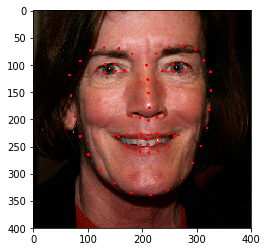

In [16]:
parameters.train_or_test = 'test'
bbox_dict = load_boxes(parameters)
parameters.demo = True
n=63
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3255054809_1.jpg
RMSE for this image is  5.95324923639085


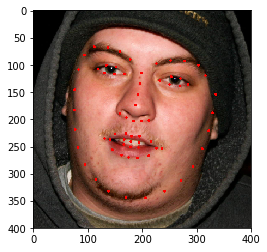

In [17]:
n = 53
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3052865023_5.jpg
RMSE for this image is  5.41919247294498


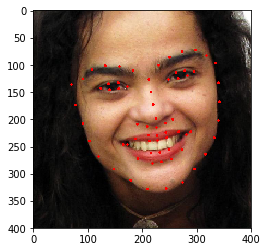

In [18]:
n = 21
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3059898383_1.jpg
RMSE for this image is  4.040238781528228


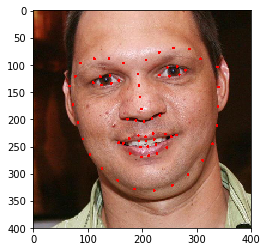

In [19]:
n = 151
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

### Bad examples

helen/testset/imgs/3213825562_1.jpg
RMSE for this image is  89.56873798111377


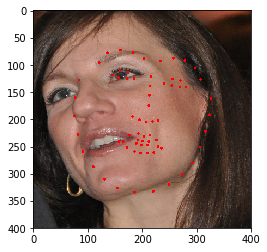

In [20]:
n=102
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3051542838_1.jpg
RMSE for this image is  34.892271181957966


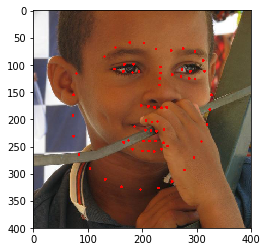

In [21]:
n=87
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/3139620200_1.jpg
RMSE for this image is  34.920708503020684


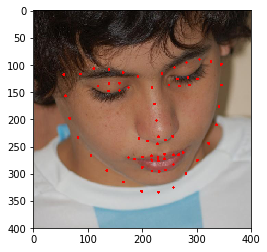

In [22]:
n=38
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)

helen/testset/imgs/2993871777_1.jpg
RMSE for this image is  19.114207835441956


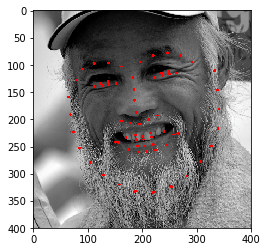

In [23]:
n=61
_,_,_ = test_one_image(W_dict[parameters.alpha], test_image_names[n],bbox_dict[test_image_names[n]],initial_landmarks,parameters)